In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os

In [2]:
class QuadraticRegression:
    
    def __init__(self, start_date, number_initial_case, addition_case_data):
        dates = pd.date_range(start_date, periods=len(addition_case_data) + 1) 
        self.start_date = start_date
        self.total_positive_accumulative = pd.DataFrame([[0, number_initial_case]], index=[dates[0]], columns=['Penambahan Kasus Positif','Total Kasus Positif'])

        cumulative_positive = number_initial_case
        for idx, addition_case in enumerate(addition_case_data):
            cumulative_positive += addition_case[1]
            temp = pd.DataFrame([[addition_case[1], cumulative_positive]], columns=['Penambahan Kasus Positif','Total Kasus Positif'], index=[dates[idx+1]])
            self.total_positive_accumulative = self.total_positive_accumulative.append(temp)
        
        self.compute_coefficients()
    
    def compute_x12(self, data_x):
        return [d for d in data_x], [d ** 2 for d in data_x]

    def compute_s11(self, x1):
        s11 = sum([x ** 2 for x in x1])
        return s11 - ((sum(x1) ** 2) / len(x1))

    def compute_s12(self, x1, x2):
        s12 = sum([x * y for x,y in zip(x1,x2)])
        return s12 - (sum(x1) * sum(x2) / len(x1))

    def compute_s22(self, x2):
        s22 = sum([x ** 2 for x in x2])
        return s22 - ((sum(x2) ** 2) / len(x2))

    def compute_y1(self, y, x1):
        sy1 = sum([x * y for x,y in zip(y, x1)])
        return sy1 - (sum(y) * sum(x1) / len(y))

    def compute_y2(self, y, x2):
        sy2 = sum([x * y for x,y in zip(y, x2)])
        return sy2 - (sum(y) * sum(x2) / len(y))

    def average(self, data):
        return sum(data) / len(data)

    def compute_coefficients(self):
        data_x = range(1, len(self.total_positive_accumulative) + 1)
        data_y = self.total_positive_accumulative['Total Kasus Positif']
        x1, x2 = self.compute_x12(data_x)
        s11 = self.compute_s11(x1)
        s12 = self.compute_s12(x1, x2)
        s22 = self.compute_s22(x2)
        sy1 = self.compute_y1(data_y, x1)
        sy2 = self.compute_y2(data_y, x2)
        avg_x1 = self.average(x1)
        avg_x2 = self.average(x2)
        avg_y = self.average(data_y)

        self.b2 = ((sy1 * s22) - (sy2 *s12)) / (s22 * s11 - (s12 ** 2))
        self.b3 = ((sy2 * s11) - (sy1 *s12)) / (s22 * s11 - (s12 ** 2))
        self.b1 = avg_y - (self.b2 * avg_x1) - (self.b3 * avg_x2)

        return self.b1, self.b2, self.b3

    def compute_prediction(self, days):
        dates = pd.date_range(self.start_date, periods=len(self.total_positive_accumulative) + days)
        
        temp = []
        for x in range(1, len(self.total_positive_accumulative) + days + 1):
            if x <= len(self.total_positive_accumulative):
                buffer = pd.DataFrame([[self.total_positive_accumulative['Penambahan Kasus Positif'][x-1], 
                                        self.total_positive_accumulative['Total Kasus Positif'][x-1],
                                        (self.b3 * (x ** 2)) + (self.b2 * x) + self.b1]],
                                      columns=['Penambahan Kasus Positif',
                                               'Total Kasus Positif',
                                               'Prediksi Total Kasus Positif'],
                                      index=[dates[x - 1]])
            else:     
                buffer = pd.DataFrame([[np.nan, 
                                        np.nan,
                                        (self.b3 * (x ** 2)) + (self.b2 * x) + self.b1]],
                                      columns=['Penambahan Kasus Positif',
                                               'Total Kasus Positif',
                                               'Prediksi Total Kasus Positif'],
                                      index=[dates[x - 1]])
            temp.append(buffer)
        
        self.prediction = pd.concat(temp)
        return self.prediction
    
    def sse(self, observed_value, predict_value):
        temp = 0
        for o,p in zip(observed_value, predict_value):
            temp += (o - p) ** 2
        return temp

    def tss(self, observed_value, avg_observed_value):
        temp = 0
        for o in observed_value:
            temp += (o - avg_observed_value) ** 2
        return temp

    def residue(self):
        observed_value = self.total_positive_accumulative['Total Kasus Positif']
        predicted_value = self.prediction['Prediksi Total Kasus Positif']
        avg_observed_value = self.average(observed_value)
        return 1 - (self.sse(observed_value, predicted_value) / self.tss(observed_value, avg_observed_value))

    def rmse(self):
        observed_value = self.total_positive_accumulative['Total Kasus Positif']
        predicted_value = self.prediction['Prediksi Total Kasus Positif']
        temp = 0
        for o,p in zip(observed_value, predicted_value):
            temp += (o - p) ** 2   
        return (temp / len(observed_value)) ** 0.5
    
    def save_data_to_sqlite(self):
        conn = sqlite3.connect('predict_data.sqlite')
        cur = conn.cursor()
        
        if not os.path.exists('predict_data.sqlite'):
            cur.execute('CREATE TABLE data_quadratic (tgl DATE, observed_x INT, observed_y INT, predicted_x INT, predicted_y INT)')
            conn.commit()

            cur.execute('CREATE TABLE quadratic_coefficients (b0 INT, b1 INT, b2 INT)')
            conn.commit()
            
        else:
            cur.execute('DROP TABLE data_quadratic')
            conn.commit()
            
            cur.execute('DROP TABLE quadratic_coefficients')
            conn.commit()
            
            cur.execute('CREATE TABLE data_quadratic (tgl DATE, observed_x INT, observed_y INT, predicted_x INT, predicted_y INT)')
            conn.commit()

            cur.execute('CREATE TABLE quadratic_coefficients (b0 INT, b1 INT, b2 INT)')
            conn.commit()
            
        dates = pd.date_range(self.start_date, periods=len(self.prediction) + 1)
        print(dates)

        for a,b,c,d,e in zip(dates, range(1, len(self.total_positive_accumulative) + 1), self.total_positive_accumulative['Total Kasus Positif'], range(1, len(self.total_positive_accumulative) + 1), self.prediction['Prediksi Total Kasus Positif']):
            cur.execute('INSERT INTO data_quadratic (tgl, observed_x, observed_y, predicted_x, predicted_y) values ("{}", {}, {}, {}, {})'.format(str(a)[:10], b, c, d, e))
            conn.commit()

        for i in range(len(self.total_positive_accumulative), len(self.prediction)):
            cur.execute('INSERT INTO data_quadratic (tgl, observed_x, observed_y, predicted_x, predicted_y) values ("{}", null, null, {}, {})'.format(str(dates[i])[:10], i+1, self.prediction['Prediksi Total Kasus Positif'][i]))
            conn.commit()

        cur.execute('INSERT INTO quadratic_coefficients (b0, b1, b2) values ({}, {}, {})'.format(self.b1, self.b2, self.b3))
        conn.commit()
        conn.close()

In [3]:
addition_case_positive_covid = [[17, 38],
                                [18, 55],
                                [19, 81],
                                [20, 61],
                                [21, 81],
                                [22, 64],
                                [23, 65],
                                [24, 106],
                                [25, 105],
                                [26, 103],
                                [27, 153],
                                [28, 109],
                                [29, 130],
                                [30, 129],
                                [31, 114],
                                [1, 149],
                                [2, 113],
                                [3, 196],
                                [4, 106],
                                [5, 181],
                                [6, 218],
                                [7, 247],
                                [8, 218],
                                [9, 337],
                                [10, 219],
                                [11, 330],
                                [12, 399],
                                [13, 316],
                                [14, 282],
                                [15, 297],
                                [16, 380],
                                [17, 407],
                                [18, 325],
                                [19, 327],
                         ]

In [4]:
covid19 = QuadraticRegression('20200316', 134, addition_case_data=addition_case_positive_covid)

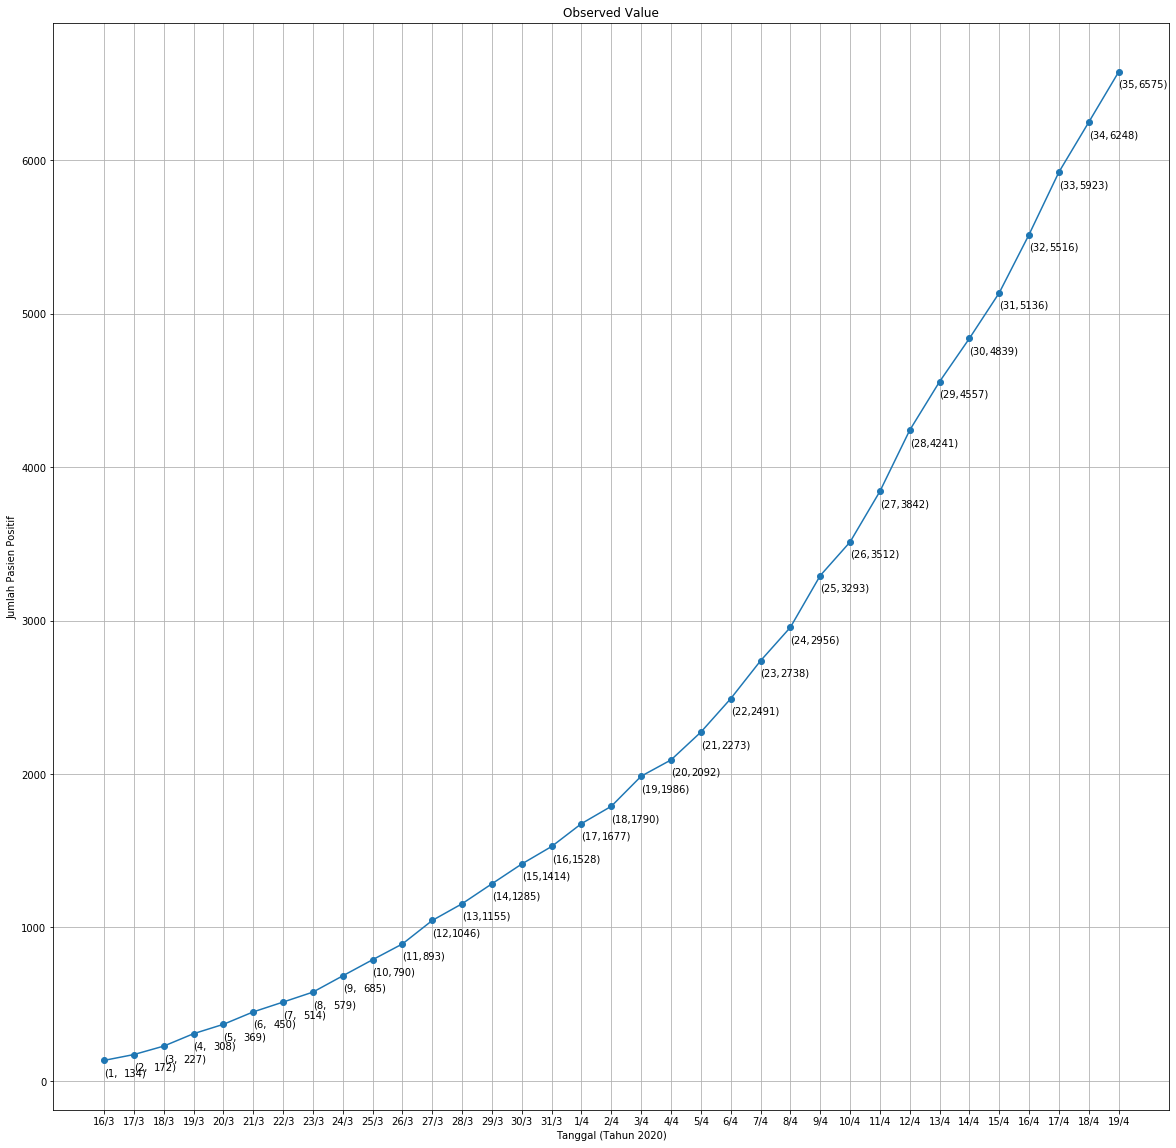

In [23]:
total_positive_accumulative = covid19.total_positive_accumulative

plt.figure(figsize=(20,20))
plt.title('Observed Value')
plt.xlabel('Tanggal (Tahun 2020)')
plt.ylabel('Jumlah Pasien Positif')

dates = pd.date_range(covid19.start_date, periods=len(total_positive_accumulative))

plt.plot([d.strftime("%-d/%-m") for d in dates], total_positive_accumulative['Total Kasus Positif'], marker='o', label='Observed Value')

for i,j in zip(range(0, len(total_positive_accumulative)), total_positive_accumulative['Total Kasus Positif']):
    plt.annotate('%i)' %j, xy=(i,j-100), xytext=(20,0), textcoords='offset points')
    plt.annotate('(%i,' %(i+1), xy=(i,j-100))
    
fig_manager = plt.get_current_fig_manager()
if hasattr(fig_manager, 'window'):
    fig_manager.window.showMaximized()

plt.grid()
plt.show()

In [25]:
prediction = covid19.compute_prediction(days=5)
prediction

,Penambahan Kasus Positif,Total Kasus Positif,Prediksi Total Kasus Positif
2020-03-16,0.0,134.0,287.531532
2020-03-17,38.0,172.0,288.951457
2020-03-18,55.0,227.0,301.421886
2020-03-19,81.0,308.0,324.942817
2020-03-20,61.0,369.0,359.514251
2020-03-21,81.0,450.0,405.136188
2020-03-22,64.0,514.0,461.808628
2020-03-23,65.0,579.0,529.531570
2020-03-24,106.0,685.0,608.305015
2020-03-25,105.0,790.0,698.128963


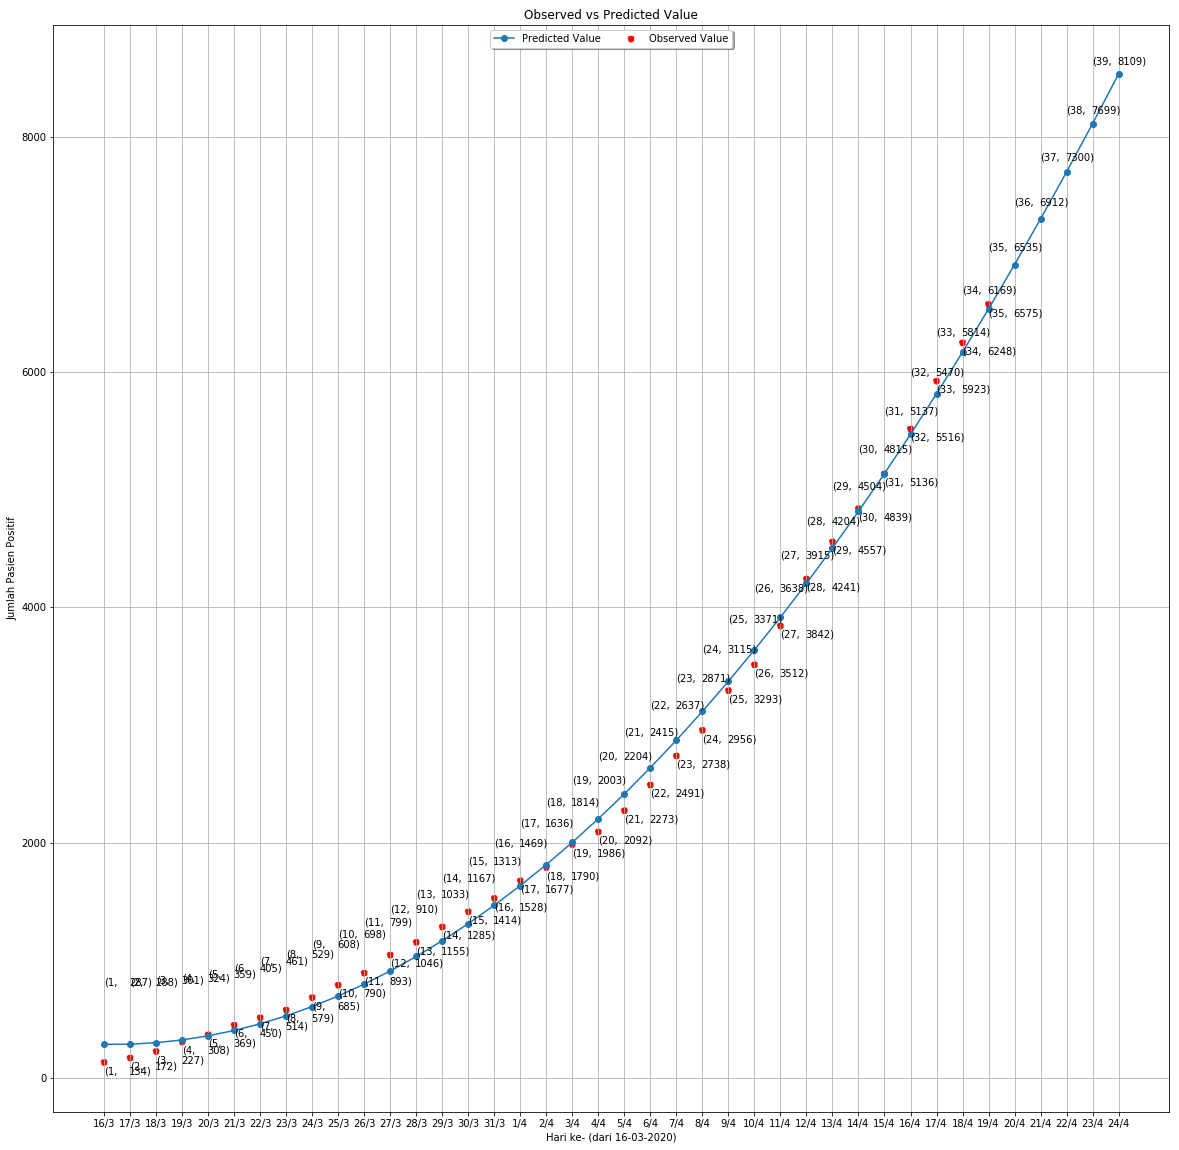

In [32]:
dates = pd.date_range(covid19.start_date, periods=len(prediction))

plt.figure(figsize=(20,20))
plt.scatter([d.strftime("%-d/%-m") for d in dates[:len(total_positive_accumulative)]], total_positive_accumulative['Total Kasus Positif'], linestyle='dashed', marker='o', c='r', label='Observed Value')
plt.plot([d.strftime("%-d/%-m") for d in dates], prediction['Prediksi Total Kasus Positif'], marker='o', label='Predicted Value')

for i,j in zip(range(0, len(total_positive_accumulative)), total_positive_accumulative['Total Kasus Positif']):
    plt.annotate('%i)' %j, xy=(i,j-100), xytext=(25,0), textcoords='offset points')
    plt.annotate('(%i,' %(i+1), xy=(i,j-100))
    
for k,l in zip(range(0, len(prediction)), prediction['Prediksi Total Kasus Positif']):
    plt.annotate('%i)' %l, xy=(k,l+500), xytext=(25,0), textcoords='offset points')
    plt.annotate('(%i,' %(k+1), xy=(k,l+500))
    
fig_manager = plt.get_current_fig_manager()
if hasattr(fig_manager, 'window'):
    fig_manager.window.showMaximized()
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
plt.xlabel('Tanggal (Tahun 2020)')
plt.ylabel('Jumlah Pasien Positif')
plt.title('Observed vs Predicted Value')

plt.grid()
plt.show()

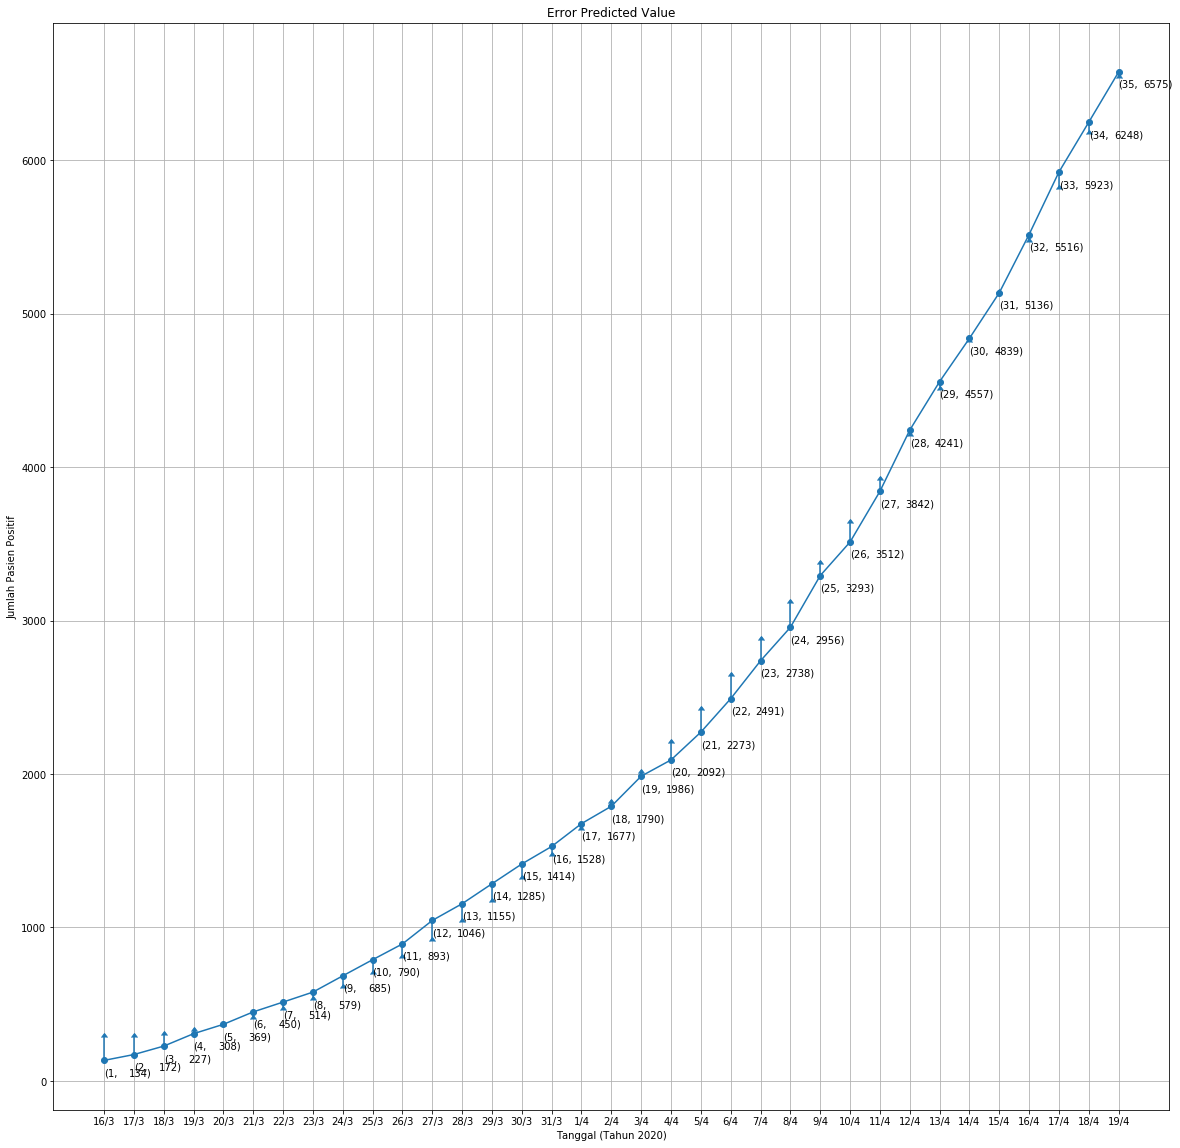

In [35]:
error = [x - y for x,y in zip(prediction['Prediksi Total Kasus Positif'], total_positive_accumulative['Total Kasus Positif'])]

plt.figure(figsize=(20,20))
plt.title('Error Predicted Value')
plt.xlabel('Tanggal (Tahun 2020)')
plt.ylabel('Jumlah Pasien Positif')

dates = pd.date_range(covid19.start_date, periods=len(total_positive_accumulative))
         
plt.errorbar([d.strftime("%-d/%-m") for d in dates], total_positive_accumulative['Total Kasus Positif'], marker='o', label='Observed Value', yerr=error, lolims=True)

for i,j in zip(range(0, len(total_positive_accumulative)), total_positive_accumulative['Total Kasus Positif']):
    plt.annotate('%i)' %j, xy=(i,j-100), xytext=(25,0), textcoords='offset points')
    plt.annotate('(%i,' %(i+1), xy=(i,j-100))
    
fig_manager = plt.get_current_fig_manager()
if hasattr(fig_manager, 'window'):
    fig_manager.window.showMaximized()

plt.grid()
plt.show()

In [9]:
covid19.residue()

0.9977775050537112

In [10]:
covid19.rmse()

90.75262077272765

In [11]:
covid19.save_data_to_sqlite()

DatetimeIndex(['2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
               '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
               '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
               '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20',
               '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
               '2020-04-25'],
              dtype='datetime64[ns]', freq='D')
